In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import *
from tensorflow.keras.regularizers import *
from tensorflow.keras.metrics import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.activations import *
from tensorflow.keras.estimator import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
import os
import pandas as pd
import glob
import pathlib
import cv2

In [2]:
# Parametres
BATCH_SIZE=32
IMG_WIDTH=150
IMG_HEIGHT=150
EPOCHS=15

# create a data generator
data_gen = ImageDataGenerator(rescale=1./255,
                rotation_range=45,
                width_shift_range=.15,
                height_shift_range=.15,
                horizontal_flip=True,
                zoom_range=0.5
                )

data_test_gen = ImageDataGenerator(rescale=1./255)

# load and iterate training dataset
train_gen = data_gen.flow_from_directory(directory='C:/Users/hakim/PycharmProjects/kaggle-competition/data/train',
                                         target_size=(IMG_WIDTH,IMG_HEIGHT),
                                         class_mode='categorical',
                                         color_mode='rgb',
                                         batch_size=BATCH_SIZE,
                                         shuffle=True,
                                         seed=42)
# load and iterate training dataset
validation_gen = data_test_gen.flow_from_directory(directory='C:/Users/hakim/PycharmProjects/kaggle-competition/data/validation',
                                         target_size=(IMG_WIDTH,IMG_HEIGHT),
                                         class_mode='categorical',
                                         color_mode='rgb',
                                         batch_size=BATCH_SIZE,
                                         shuffle=False,
                                         seed=42)
# load and iterate test dataset
test_gen = data_gen.flow_from_directory(directory='C:/Users/hakim/PycharmProjects/kaggle-competition/data/test',
                                        target_size=(IMG_WIDTH,IMG_HEIGHT),
                                        class_mode='categorical',
                                        color_mode='rgb',
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        seed=42)

Found 1445 images belonging to 4 classes.
Found 408 images belonging to 4 classes.
Found 1821 images belonging to 1 classes.


(150, 150, 3)
(150, 150, 3)
(150, 150, 3)
(150, 150, 3)
(150, 150, 3)


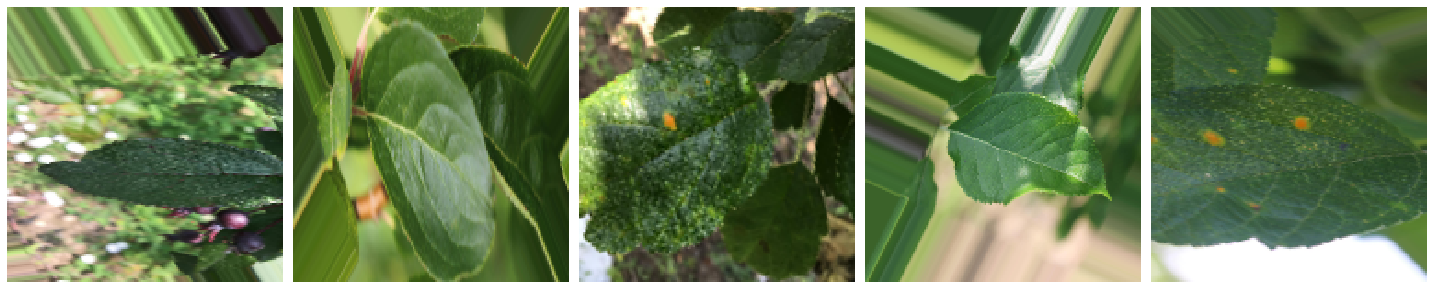

In [3]:
# plot some images
sample_training, _ = next(train_gen)

def plotImage(images):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images, axes):
        print(img.shape)
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImage((sample_training[:5]))

In [5]:
def lr_optimizer(epoch):
    lr = 1e-3
    if (epoch == 30):
        lr *= 1e-1
    elif(epoch == 70):
        lr *= 1e-1
    else:
        lr *= 0.5e-1

In [ ]:
class PlotRealLossAndAccuracyOnTrainCallback(Callback):

    def __init__(self, x_train, y_train):
        super().__init__()
        self.x_train = x_train
        self.y_train = y_train

    def on_epoch_end(self, epoch, logs=None):
        (loss, acc) = self.model.evaluate(self.x_train, self.y_train, batch_size = 8192)
        print(f"Real Loss on train : {loss}")
        print(f"Real Acc on train : {acc}")


In [28]:
def create_model():
    
    model = Sequential()

    model.add(Conv2D(16, (3, 3), padding='same',activation=relu,input_shape=(IMG_WIDTH,IMG_HEIGHT, 3)))
    model.add(MaxPooling2D())
    model.add(Dropout(0.3))

    model.add(Conv2D(32, (3, 3),padding='same',activation=relu))
    model.add(MaxPooling2D())
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (3, 3),padding='same',activation=relu))
    model.add(MaxPooling2D())
    model.add(Dropout(0.3))
    
    model.add(Flatten())

    model.add(Dense(512, activation=relu))#, kernel_regularizer=l1_l2(l2=0.01) ))
    model.add(Dropout(0.3))

    model.add(Dense(4, activation=softmax))

    # compile the model
    model.compile(loss=categorical_crossentropy,
                  optimizer=Adam(),
                  metrics=['accuracy'])
    return model


def create_model2():
    model = Sequential()

    model.add(Conv2D(16, (3, 3), padding='same',activation=relu, input_shape=(IMG_WIDTH,IMG_HEIGHT, 3)))
    model.add(Conv2D(16, (3, 3), padding='same', activation=relu))
    model.add(MaxPooling2D())
    model.add(Dropout(0.3))

    model.add(Conv2D(32, (3, 3), padding='same', activation=relu))
    model.add(Conv2D(32, (3, 3), padding='same', activation=relu))
    model.add(MaxPooling2D())
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), padding='same', activation=relu))
    model.add(Conv2D(64, (3, 3), padding='same', activation=relu))
    model.add(MaxPooling2D())
    model.add(Dropout(0.2))

    model.add(Flatten())

    model.add(Dense(512, activation=relu))#,  kernel_regularizer=l1_l2(l2=0.01) ))
    model.add(Dropout(0.4))

    model.add(Dense(4, activation=softmax))

    # compile the model
    model.compile(loss=categorical_crossentropy,
                  optimizer=Adam(),
                  metrics=['accuracy'])

    
    return model

In [29]:
# summary
model = create_model()
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 75, 75, 16)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 37, 37, 64)       

#train_model

In [30]:
history=model.fit_generator(generator=train_gen, 
                    steps_per_epoch=train_gen.n//train_gen.batch_size, 
                    epochs=120,
                    validation_data=validation_gen,
                    validation_steps=validation_gen.n//validation_gen.batch_size)

Epoch 1/120
45/45 [==============================] - 53s 1s/step - loss: 1.8613 - accuracy: 0.3800 - val_loss: 1.3473 - val_accuracy: 0.3698
Epoch 2/120
45/45 [==============================] - 52s 1s/step - loss: 1.2832 - accuracy: 0.4091 - val_loss: 1.3510 - val_accuracy: 0.3698
Epoch 3/120
45/45 [==============================] - 51s 1s/step - loss: 1.2645 - accuracy: 0.4069 - val_loss: 1.3621 - val_accuracy: 0.3698
Epoch 4/120
45/45 [==============================] - 50s 1s/step - loss: 1.2276 - accuracy: 0.4374 - val_loss: 1.3181 - val_accuracy: 0.3698
Epoch 5/120
45/45 [==============================] - 49s 1s/step - loss: 1.2683 - accuracy: 0.4161 - val_loss: 1.3617 - val_accuracy: 0.3828
Epoch 6/120
45/45 [==============================] - 49s 1s/step - loss: 1.2398 - accuracy: 0.4317 - val_loss: 1.3412 - val_accuracy: 0.3828
Epoch 7/120
45/45 [==============================] - 48s 1s/step - loss: 1.2922 - accuracy: 0.4091 - val_loss: 1.3243 - val_accuracy: 0.3698
Epoch 8/120
4

Epoch 58/120
45/45 [==============================] - 44s 969ms/step - loss: 0.7001 - accuracy: 0.7162 - val_loss: 1.0235 - val_accuracy: 0.5729
Epoch 59/120
45/45 [==============================] - 44s 985ms/step - loss: 0.6914 - accuracy: 0.7201 - val_loss: 0.8812 - val_accuracy: 0.6458
Epoch 60/120
45/45 [==============================] - 44s 975ms/step - loss: 0.7256 - accuracy: 0.7077 - val_loss: 0.8101 - val_accuracy: 0.6953
Epoch 61/120
45/45 [==============================] - 44s 978ms/step - loss: 0.7063 - accuracy: 0.7268 - val_loss: 0.9368 - val_accuracy: 0.6094
Epoch 62/120
45/45 [==============================] - 43s 955ms/step - loss: 0.6845 - accuracy: 0.7179 - val_loss: 0.8392 - val_accuracy: 0.6693
Epoch 63/120
45/45 [==============================] - 43s 964ms/step - loss: 0.6863 - accuracy: 0.7332 - val_loss: 0.8967 - val_accuracy: 0.6302
Epoch 64/120
45/45 [==============================] - 43s 961ms/step - loss: 0.7004 - accuracy: 0.7247 - val_loss: 0.9489 - val_ac

In [138]:
# save weights
#model.save_weights('weights_first_try.h5')
#model.save('model_first_try.h5')

# load model
# from keras.models import load_model
# model = load_model('model_first_try.h5')

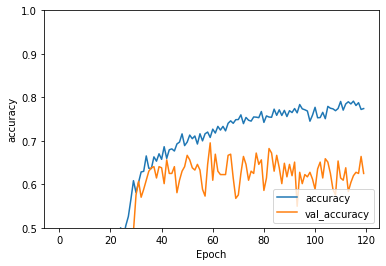

In [31]:

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

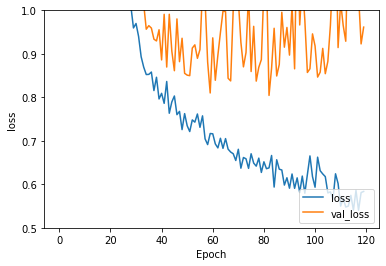

In [32]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [23]:
# evaluating the model
model.evaluate_generator(generator=validation_gen,
                         steps=validation_gen.n//validation_gen.batch_size)

[1.0752593434105318, 0.671875]

In [26]:
# predict the output
test_gen.reset()
pred = model.predict_generator(test_gen,
                               steps=test_gen.n//test_gen.batch_size,
                               verbose=1)

56/56 [==============================] - 55s 987ms/step


In [25]:
# reset the test generator
predicted_class_indices = np.argmax(pred,axis=1)

In [27]:
# map predictions
tmp_filenames = [id[5:20] for id in test_gen.filenames]
filenames=[]
for file in tmp_filenames:
    f = file.split('.')
    filenames.append(f[0])
    
df = pd.DataFrame({'image_id': filenames})
df = df.join(pd.DataFrame(data=pred, columns=train_gen.class_indices.keys()))

df.head(10)

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.016419,0.146730,0.043517,0.793334
1,Test_1,0.138453,0.380188,0.045712,0.435647
2,Test_10,0.034510,0.203967,0.007400,0.754123
3,Test_100,0.940762,0.007874,0.031390,0.019975
4,Test_1000,0.801726,0.043965,0.068048,0.086261
5,Test_1001,0.000359,0.002396,0.997142,0.000103
6,Test_1002,0.948697,0.003200,0.039033,0.009070
7,Test_1003,0.019893,0.034603,0.939059,0.006444
8,Test_1004,0.002273,0.085757,0.910493,0.001477
9,Test_1005,0.322329,0.328793,0.293518,0.055360


In [141]:
df.to_csv("results1.csv", index=False)